# Проект: Статистический анализ данных
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.  
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:  
* без подписки 
    * абонентская плата отсутствует;  
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

# Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи** — `users_go.csv`  
`user_id` - уникальный идентификатор пользователя  
`name` - имя пользователя  
`age` - возраст  
`city` - город  
`subscription_type` - тип подписки (free, ultra)  

**Поездки** — `rides_go.csv`  
`user_id` - уникальный идентификатор пользователя  
`distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)  
`duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
`date` - дата совершения поездки  

**Подписки** — `subscriptions_go.csv`  
`subscription_type` - тип подписки  
`minute_price` - стоимость одной минуты поездки по данной подписке  
`start_ride_price` - стоимость начала поездки  
`subscription_fee` - стоимость ежемесячного платежа  

#### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import binom

### Загрузка данных

#### Считаем CSV-файлы и зададим переменные

In [2]:
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

#### Просмотр первых 5 строк каждой таблицы

In [3]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Общая информация о каждой таблице и проверка на дубликаты

In [6]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
print('Количество дубликатов:', users_go.duplicated().sum())

Количество дубликатов: 31


In [8]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [9]:
print('Количество дубликатов:', rides_go.duplicated().sum())

Количество дубликатов: 0


In [10]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [11]:
print('Количество дубликатов:', subscriptions_go.duplicated().sum())

Количество дубликатов: 0


#### Вывод

После изучения данных можно сделать следующие выводы:
1. В таблице `users_go`(пользователи) всего 1565 записей, в которых есть 31 явных дубликатов. Пропусков нет.
2. В таблице `rides_go`(поездки) всего 18068 записей и 0 явных дубликатов. Пропусков нет.
3. В таблице `subscriptions_go`(подписки) всего 2 записи и 0 явных дубликатов. Пропусков нет.  

Ошибок или неточностей в названии столбцов нет. Некоторые столбцы имеют некорректный тип данынх.

### Предобработка данных

#### Предобработка `users_go`

In [12]:
# Удаление явных дубликатов
users_go = users_go.drop_duplicates()

#### Предобработка `rides_go`

In [13]:
# В столбце distance слишком много знаков после запятой, уменьшим их количество до 2
rides_go['distance'] = rides_go['distance'].round(2)
# Столбец duration показывает сколько времени самокат был в аренде. 
# Нам нужны значения полных минут со сдвигом вверх, поэтому уберем все значения после запятой изменив тип даных на Int
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')
# В столбце date нужно изменить тип данных на дату
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')
# Создадим навый столбец month в котором будут записаны номера месяцев из таблицы date 
rides_go['month'] = rides_go['date'].dt.month
rides_go.info()
rides_go.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  int64         
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 705.9 KB


,user_id,distance,duration,date,month
0,1,4409.92,26,2021-01-01,1
1,1,2617.59,16,2021-01-18,1
2,1,754.16,7,2021-04-20,4
3,1,2694.78,19,2021-08-11,8
4,1,4028.69,27,2021-08-28,8


#### Предобработка `subscriptions_go` не требуется

#### Вывод

Во время проведения предобработки данных были выполнены следующие действия:
1. В таблице `users_go` были удалены дубликаты. До удаления было 1565 записей, после - 1534.

2. В таблице `rides_go`:
    * Округлены все значения в столбце `distance` до 2 знаков после запятой.
    * Округлены все значения в столбце `duration` до целых значений вверх (пункт 5.2) и изменен тип данных на int.
    * В столбце `date` изменен тип данынх на datetime.
    * Добавлен новый столбец `month` содержащий номер месяца (пункт 2.2).
    
    
3. В таблице `subscriptions_go` не было проведено никаких изменений.

### Исследовательский анализ данных

#### Частота встречаемости городов

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


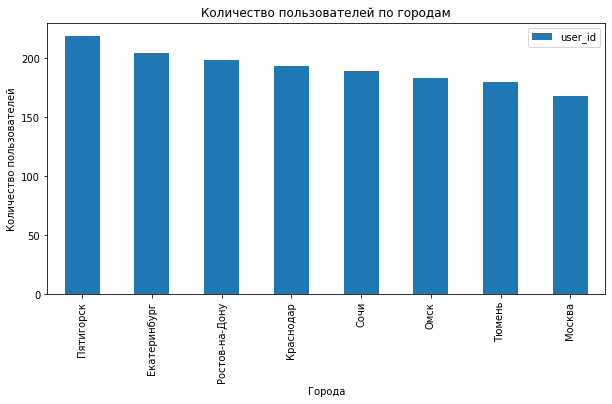

In [14]:
(
    users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)
    .plot(title='Количество пользователей по городам', xlabel='Города', ylabel='Количество пользователей', kind='bar', 
          figsize=(10, 5))
)

users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

Больше всего пользователей в Пятигорске, в то время как меньше всего в Москве. Также можно заметить что больше пользователей в южных городах, кроме Екатеринбурга, который располагается на 2 месте.

#### Соотношение пользователей с подпиской и без подписки

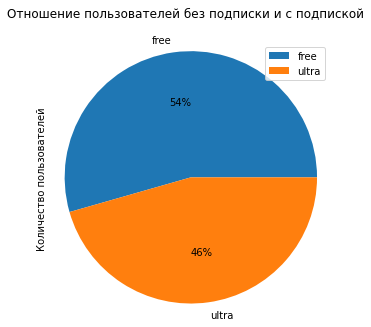

In [15]:
(
    users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot(kind='pie', subplots=True, figsize=(5,5),  ylabel='Количество пользователей', autopct='%.0f%%',    
    title='Отношение пользователей без подписки и с подпиской')

)
plt.axis('equal')
plt.show()

Больше половины(54%) пользователей пользуются приложением без подписки(46%).

#### Возраст пользователей

,user_id
age,
12,4
13,8
14,9
15,13
16,19
17,26
18,46
19,47
20,71


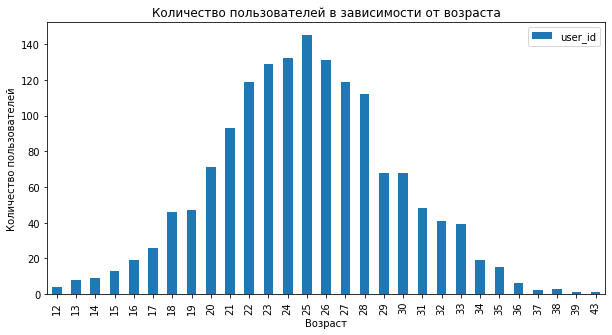

In [16]:
(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True).
    plot(kind='bar', title='Количество пользователей в зависимости от возраста', 
         xlabel='Возраст', ylabel='Количество пользователей', figsize=(10,5))
)
users_go.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True)

По графику видно что возраст пользователей от 12 до 43 лет. Также видно больше всего пользователей 25 лет.

#### Расстояние, которое пользователь преодолел за одну поездку

In [17]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

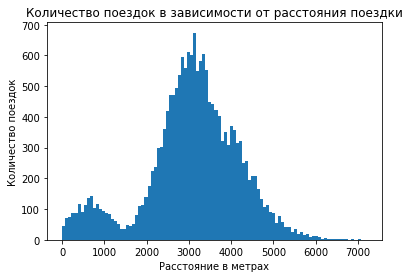

In [18]:
plt.hist(rides_go['distance'], bins=100, range=(1,7211))
plt.title('Количество поездок в зависимости от расстояния поездки')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

Максимальное расстояние которое преодолевали пользователи - 7211 метров, самое же минимальное - 1 метр. Среднее расстояние, которое преодолевают пользователи - 3070 метров. Также есть относительно небольшая группа пользователей произжающих короткие дистанции до 1500 метров.

#### Продолжительность поездок

In [19]:
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

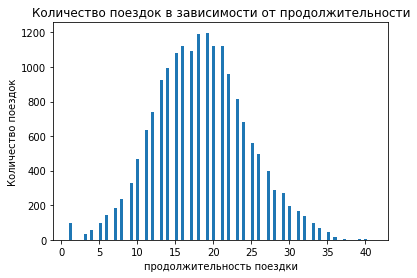

In [20]:
plt.hist(rides_go['duration'], bins=100, range=(1,41))
plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Минимальное время поздки 1 минута, максимальное - 41 минута. Самое большое количество поездок находится в пределах 18 минут.

#### Вывод

По итогу исследования можно сделать несколько выводов:
1. Чаще услугами сервиса пользуются в южных регионах страны(скорее всего это связано с тем что сезон проката там дольше, чем в других регионах), однако в Екатеринбурге спрос на сервис выше чем во многих южных городах.
2. Больше половины(54%) пользователей пользуются приложением без подписки(46%).
3. Возраст пользователу сервиса от 12 до 43 лет. Самое большое количество пользователей в возрасте 25 лет.
4. Максимальное расстояние которое преодолевали пользователи - 7211 метров, самое же минимальное - 1 метр. Среднее расстояние, которое преодолевают пользователи - 3070 метров. Также есть относительно небольшая группа пользователей произжающих короткие дистанции до 1500 метров.
5. Минимальное время поздки 1 минута, максимальное - 41 минута. Самое большое количество поездок находится в пределах 18 минут.

### Объединение данных

#### Объедините данные о пользователях, поездках и подписках в один датафрейм

In [21]:
df = users_go.merge(rides_go, on='user_id').merge(subscriptions_go, on='subscription_type')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int64         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.8+ MB


Созданный датафрейм `df` объединяет в себе таблицы `users_go` `rides_go` и `subscriptions_go`. В итоге датафрейм имеет 18067 строк, количество которых соответствует самой большой по размеру таблице `rides_go`. 

#### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1

##### С данными о пользователях без подписки

In [22]:
df_free = df[df['subscription_type'] == 'free']
df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,17,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,21,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,18,2021-02-14,2,8,50,0


##### С данными о пользователях с подпиской

In [23]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


#### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

##### Количество поездок в зависимости от расстояния

In [24]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

In [25]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

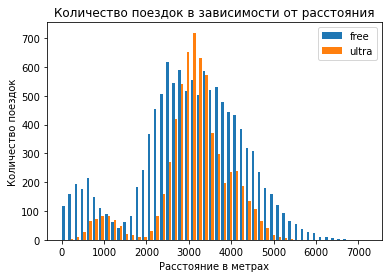

In [26]:
plt.hist([df_free['distance'], df_ultra['distance']], bins=50, range=(1,7211), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости от расстояния')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

##### Количество поездок в зависимости от времени поездки

In [27]:
df_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [28]:
df_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

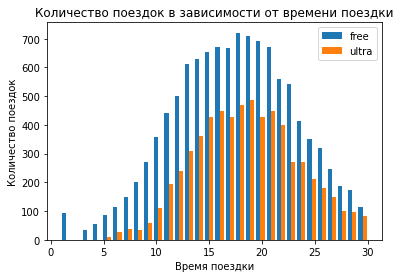

In [29]:
plt.hist([df_free['duration'], df_ultra['duration']], bins=30, range=(1,30), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости от времени поездки')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')
plt.show()

#### Вывод

По итогу объединения и визуализации данных по типу подписки можно сделать следующий вывод:
1. Тип подписки влияет на среднее расстояние, которое проезжают пользователи. Пользователи без подписки проезжают расстояние меньше, чем пользователи с подпиской (3045 против 3115). Также у пользователей без подписки разброс выше, чем у пользователей с подпиской (1246 и 836).
2. Тип подписки влияет на время поездки. Пользователи без подписки в среднем тратят времени на поездки меньше, чем пользователи с подпиской (в среднем 18 минут без подписки и 19 минут с подпиской). 

### Подсчёт выручки

#### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [30]:
users_months_rides = df.pivot_table(
    index=('user_id', 'month'), 
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee'
    ), 
    aggfunc=({'distance':{'count', 'sum'}, 
             'duration':'sum',
             'minute_price': 'mean',
             'start_ride_price':'mean',
             'subscription_fee':'mean',})
)
users_months_rides.columns = [
    'rides_count', 'distance', 
    'duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee'
]
users_months_rides.head()

rides_count  distance  duration  minute_price  \
user_id month                                                  
1       1                2   7027.51        42             6   
        4                1    754.16         7             6   
        8                2   6723.47        46             6   
        10               2   5809.91        32             6   
        11               3   7003.50        56             6   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                     0               199  
        4                     0               199  
        8                     0               199  
        10                    0               199  
        11                    0               199

####  В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [31]:
users_months_rides['revenue'] = (
users_months_rides['start_ride_price']*users_months_rides['rides_count']+
users_months_rides['minute_price']*users_months_rides['duration']+
users_months_rides['subscription_fee'])
users_months_rides.head()

rides_count  distance  duration  minute_price  \
user_id month                                                  
1       1                2   7027.51        42             6   
        4                1    754.16         7             6   
        8                2   6723.47        46             6   
        10               2   5809.91        32             6   
        11               3   7003.50        56             6   

               start_ride_price  subscription_fee  revenue  
user_id month                                               
1       1                     0               199      451  
        4                     0               199      241  
        8                     0               199      475  
        10                    0               199      391  
        11                    0               199      535

#### Вывод и подсчет выручки

In [32]:
print('Записи с ', df['date'].min(), 'по', df['date'].max())
print ('Выручка за 2021 год составила :',users_months_rides['revenue'].sum(), 'руб.')

Записи с  2021-01-01 00:00:00 по 2021-12-30 00:00:00
Выручка за 2021 год составила : 3878641 руб.


В общей сложности за 2021 год пользователи принести 3 878 641 рублей

### Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

#### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Выдвинем следующие гипотезы:
1. H0:Средняя продолжительность поездок с подпиской и без равна
2. H1:Средняя продолжительность поездок с подпиской больше продолжительности поездок без подписок 

Проверим гипотезы используя исходные данные о продолжительности сессии для пользователей с подпиской и без неё

In [33]:
res = stats.ttest_ind(
    df_ultra['duration'], 
    df_free['duration'], 
    equal_var=True, 
    alternative='greater')
print(res.pvalue)

alpha = 0.05
if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

2.4959453720736625e-34
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Значит можно утверждать что средняя продолжительность поездки пользователей с подпиской больше продолжительности поездок пользователей без подписки (при установленном уровне значимости в 5 %)

#### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Выдвинем следующие гипотезы:
1. H0:Среднее расстояние поездок с подпиской равно оптимальному расстоянию в 3130 метров.
2. H1:Среднее расстояние поездок с подпиской больше оптимального в 3130 метров.

Проверим гипотезы используя данные только о пользователях с подпиской.

In [34]:
distance = 3130
alpha = 0.05

res = stats.ttest_1samp(
    df_ultra['distance'], 
    distance,
    alternative='greater')

print(res.pvalue)

if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу не удалось отвергнуть. Значит можно утверждать что среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстоянием в 3130 метров с точки зрения износа самоката (при установленном уровне значимости в 5 %)

#### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Выдвинем следующие гипотезы:
1. Н0: Помесячная средняя выручка от пользователей с подпиской равна помесячной средней выручке от пользователей без подписки.
2. Н1: Помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки.

Проверим гипотезы используя данные всех пользователей с подпиской и без.

In [35]:
res = stats.ttest_ind(
    users_months_rides.loc[users_months_rides['subscription_fee'] > 0, 'revenue'], 
    users_months_rides.loc[users_months_rides['subscription_fee'] == 0, 'revenue'], 
    equal_var=True, 
    alternative='greater')
print(res.pvalue)

alpha = 0.05
if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Значит можно утверждать что средняя выручка с пользователей с подпиской выше, чем без неё (при установленном уровне значимости в 5 %).

#### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

H0 : μ1 = μ2
H1 : μ1 != μ2
где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: `scipy.stats.ttest_rel()`

#### Вывод

1. Нулевая гипотеза отвергнута. Значит можно утверждать что средняя продолжительность поездки пользователей с подпиской больше продолжительности поездок пользователей без подписки (при установленном уровне значимости в 5 %)
2. Нулевую гипотезу не удалось отвергнуть. Значит можно утверждать что среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстоянием в 3130 метров с точки зрения износа самоката (при установленном уровне значимости в 5 %)
3. Нулевая гипотеза отвергнута. Значит можно утверждать что средняя выручка с пользователей с подпиской выше, чем без неё (при установленном уровне значимости в 5 %).

### Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

При раздаче промокодов в количестве 1161 вероятность, не выполнить план меньше 5.0 %


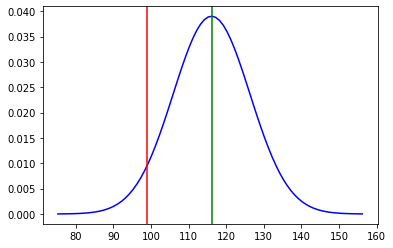

In [36]:
n = 1000
p = 0.1
k = 99
binom_cdf = 0.05

while binom_cdf < binom.cdf(k, n, p):
    n += 1
print(f'При раздаче промокодов в количестве {n} вероятность, не выполнить план меньше {binom.cdf(k, n, p).round(2)*100} %')

mu = n * p
sigma = (n * p * (1 - p))**0.5

arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)

plt.plot(arange, stats.norm.pdf(arange, mu, sigma), 'b-')
plt.axvline(x=k, color='red')
plt.axvline(x=mu, color='green')
plt.show()

Для того чтобы хотя бы 100 клиентов продлили подписку необходимо разослать как минимум 1161 уведомлений (для 5% вероятности не выполнить план)

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность открытия сообщений: 0.15371708296369768


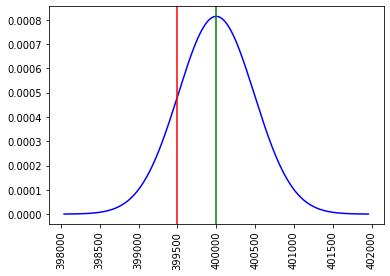

In [37]:
n = 1000000
p = 0.4
k = 399500

mu = n * p
sigma = (n * p * (1 - p))**0.5

distr = stats.norm(mu, sigma) 

result = distr.cdf(k)
print('Вероятность открытия сообщений:', result)

arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)
plt.plot(arange, stats.norm.pdf(arange, mu, sigma), 'b-')
plt.xticks(rotation=90)
plt.axvline(x=k, color='red')
plt.axvline(x=mu, color='green')
plt.show()

Если разослать 1 млн уведомлений пользователям, которые откроют сообщение с 40% вероятностью, то вероятность того что пользователи откроют уведомление не более 399,5 тыс составляет 15%.

### Общий вывод

По итогу проделанной работы можно сделать следующие выводы:
1. Загрузка данных
    * В таблице `users_go`(пользователи) всего 1565 записей, в которых есть 31 явных дубликатов. Пропусков нет.
    * В таблице `rides_go`(поездки) всего 18068 записей и 0 явных дубликатов. Пропусков нет.
    * В таблице `subscriptions_go`(подписки) всего 2 записи и 0 явных дубликатов. Пропусков нет.  
    * Ошибок или неточностей в названии столбцов нет. Некоторые столбцы имеют некорректный тип данынх.
    

2. Предобработка данных
    * В таблице `users_go` были удалены дубликаты. До удаления было 1565 записей, после - 1534.
    * В таблице `rides_go`:
        * Округлены все значения в столбце `distance` до 2 знаков после запятой.
        * Округлены все значения в столбце `duration` до целых значений вверх (пункт 5.2) и изменен тип данных на int.
        * В столбце `date` изменен тип данынх на datetime.
        * Добавлен новый столбец `month` содержащий номер месяца (пункт 2.2).
    * В таблице `subscriptions_go` не было проведено никаких изменений.
    
    
3. Исследовательский анализ данных
    * Чаще услугами сервиса пользуются в южных регионах страны(скорее всего это связано с тем что сезон проката там дольше, чем в других регионах), однако в Екатеринбурге спрос на сервис выше чем во многих южных городах.
    * Больше половины(54%) пользователей пользуются приложением без подписки(46%).
    * Возраст пользователу сервиса от 12 до 43 лет. Самое большое количество пользователей в возрасте 25 лет.
    * Максимальное расстояние которое преодолевали пользователи - 7211 метров, самое же минимальное - 1 метр. Среднее расстояние, которое преодолевают пользователи - 3070 метров. Также есть относительно небольшая группа пользователей произжающих короткие дистанции до 1500 метров.
    * Минимальное время поздки 1 минута, максимальное - 41 минута. Самое большое количество поездок находится в пределах 18 минут.
    

4. Объединение данных
    * Тип подписки влияет на среднее расстояние, которое проезжают пользователи. Пользователи без подписки проезжают расстояние меньше, чем пользователи с подпиской (3045 против 3115). Также у пользователей без подписки разброс выше, чем у пользователей с подпиской (1246 и 836).
    * Тип подписки влияет на время поездки. Пользователи без подписки в среднем тратят времени на поездки меньше, чем пользователи с подпиской (в среднем 18 минут без подписки и 19 минут с подпиской). 
    
    
5. Подсчет выручки
    * В общей сложности за 2021 год пользователи принести 3 878 641 рублей.
    
    
6. Проверка гипотез
    * После проведения статистического анализа данных была отвергнута нулевая гипотеза, что означает, что средняя продолжительность поездок пользователей с подпиской значимо превышает продолжительность поездок пользователей без подписки на уровне значимости 5%. Это означает, что пользователи с подпиской склонны дольше пользоваться услугами компании, чем пользователи без подписки.
    * На основании проведенного анализа данных нулевая гипотеза о том, что среднее расстояние поездки пользователей с подпиской превышает оптимальное значение в 3130 метров, не была отвергнута на уровне значимости 5%. Это означает, что пользователи с подпиской обычно выбирают расстояния на поездки, которые не превышают оптимальное значение, установленное для износа самоката.
    * После статистического анализа данных была отвергнута нулевая гипотеза о том, что средняя выручка от пользователей с подпиской и без нее одинакова. Это означает, что средняя выручка от пользователей с подпиской значимо выше, чем от пользователей без подписки, на уровне значимости 5%. Это может быть интересным выводом для компании, так как показывает, что подписка может стимулировать пользователей к большему объему пользования услугами и, как следствие, к увеличению выручки.
    
    
7. Распределения
    * Для того чтобы хотя бы 100 клиентов продлили подписку необходимо разослать как минимум 1161 уведомлений (для 5% вероятности не выполнить план)
    * Если разослать 1 млн уведомлений пользователям, которые откроют сообщение с 40% вероятностью, то вероятность того что пользователи откроют уведомление не более 399,5 тыс составляет 15%.